# Multimodal Fusion Music Recommendation System

The purpose of this notebook is to perform the full data extraction, preprocessing, loading, and model pipeline.

In [1]:
%load_ext autoreload
%autoreload 2

## Data Extraction

In [ ]:
# Install the required packages
%pip install -r requirements.txt

In [95]:
# Download the dataset
!bash download_dataset.sh

Directory 'data' already exists.
Starting download from: http://www.ee.columbia.edu/~thierry/artist_term.db
--2024-11-20 18:22:56--  http://www.ee.columbia.edu/~thierry/artist_term.db
Resolving www.ee.columbia.edu (www.ee.columbia.edu)... 162.159.128.65, 162.159.138.64
Connecting to www.ee.columbia.edu (www.ee.columbia.edu)|162.159.128.65|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://www.ee.columbia.edu/~thierry/artist_term.db [following]
--2024-11-20 18:22:56--  https://www.ee.columbia.edu/~thierry/artist_term.db
Connecting to www.ee.columbia.edu (www.ee.columbia.edu)|162.159.128.65|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 138974208 (133M)
Saving to: ‘data/artist_term.db’

data/artist_term.db 100%[===================>] 132.54M  9.12MB/s    in 15s     

2024-11-20 18:23:12 (8.72 MB/s) - ‘data/artist_term.db’ saved [138974208/138974208]

Download completed successfully. Saved as 'data/artist_term.db'.
S

## Preprocessing

In [2]:
from preprocessing.util.processor import Processor

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Read data from databases/datasets, do some basic preprocessing, and save them as DataFrames serialized to pickle files.

In [17]:
processor = Processor(debug_messages=True)
processor.process()
processor.save_data()

Reading user listening history file: 48373586it [00:17, 2785160.16it/s]


Read 48373586 user triplets.
Reading mbtags from data/artist_term.db
Reading metadata from data/track_metadata.db
Database connected.
Columns in 'lyrics' table: ['track_id', 'mxm_tid', 'word', 'count', 'is_test', 'song_id']
'song_id' column already exists.
Lyrics table processed and pivoted with song_id as index.
Database connection closed.


## Loading

In [19]:
from models.data_provider import DataProvider

In [38]:
data_provider = DataProvider(
    label_embedding_technique='w2v',
    embedding_config={
        'vector_size': 100,
        'window': 5,
        'min_count': 5,
        'workers': 4,
        'sg': 1
    },
    save_embeddings_to_file=True,
    load_embeddings_from_file=True,
    clustering_method='kmeans',
    debug=True
)

In [39]:
data_provider.load_data()

Reading labels.
Reading tagged metadata.
Reading untagged metadata.
Reading lyrics.
Reading user data.


In [40]:
data_provider.generate_training_classes(cluster_config={'n_clusters': 10})

Generating training classes.
Reading label embedding dictionary from data/embeddings/label_embeddings/embedding_w2v.pkl.
Aggregating embeddings for all tracks.
Clustering mbtag_embedding.


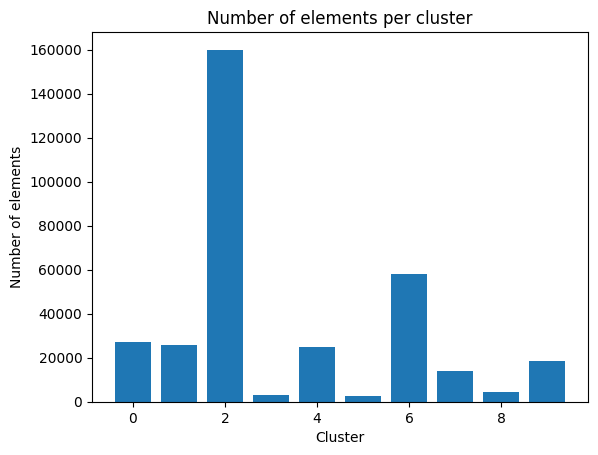

In [41]:
data_provider.plot_cluster_distribution()

In [43]:
data_provider.untagged_metadata_df.head()

,track_id,title,song_id,release,artist_id,artist_mbid,artist_name,duration,artist_familiarity,artist_hotttnesss,year,track_7digitalid,shs_perf,shs_work
0,TRMMMYQ128F932D901,Silent Night,SOQMMHC12AB0180CB8,Monster Ballads X-Mas,ARYZTJS1187B98C555,357ff05d-848a-44cf-b608-cb34b5701ae5,Faster Pussy cat,252.05506,0.649822,0.394032,2003,7032331,-1,0
1,TRMMMKD128F425225D,Tanssi vaan,SOVFVAK12A8C1350D9,Karkuteillä,ARMVN3U1187FB3A1EB,8d7ef530-a6fd-4f8f-b2e2-74aec765e0f9,Karkkiautomaatti,156.55138,0.439604,0.356992,1995,1514808,-1,0
2,TRMMMRX128F93187D9,No One Could Ever,SOGTUKN12AB017F4F1,Butter,ARGEKB01187FB50750,3d403d44-36ce-465c-ad43-ae877e65adc4,Hudson Mohawke,138.97098,0.643681,0.437504,2006,6945353,-1,0
3,TRMMMCH128F425532C,Si Vos Querés,SOBNYVR12A8C13558C,De Culo,ARNWYLR1187B9B2F9C,12be7648-7094-495f-90e6-df4189d68615,Yerba Brava,145.05751,0.448501,0.372349,2003,2168257,-1,0
4,TRMMMWA128F426B589,Tangle Of Aspens,SOHSBXH12A8C13B0DF,Rene Ablaze Presents Winter Sessions,AREQDTE1269FB37231,,Der Mystic,514.29832,0.000000,0.000000,0,2264873,-1,0


## Model

Generate an embedding vector for each song's metadata

In [49]:
from models.metadata_model import MetadataModel

In [ ]:
generic_w2v_encoder_config = {
    'embedding_technique': 'w2v',
    'aggregation_technique': 'mean',
    'load_from_file': False,
    'save_to_file': True,
    'vector_size': 100,
    'window': 5,
    'min_count': 5,
    'workers': 4,
    'sg': 1
}
metadata_model = MetadataModel(
    metadata_df=data_provider.tagged_metadata_df,
    configs={
        'title_encoder': generic_w2v_encoder_config,
        'release_encoder': generic_w2v_encoder_config,
        'artist_name_encoder': generic_w2v_encoder_config
    },
    debug=True
)

In [66]:
metadata_model.get_metadata_embeddings()

Reading label embedding dictionary from data/embeddings/title_embeddings/embedding_w2v.pkl.
Reading label embedding dictionary from data/embeddings/release_embeddings/embedding_w2v.pkl.
Reading label embedding dictionary from data/embeddings/artist_name_embeddings/embedding_w2v.pkl.


,track_id,title,song_id,release,artist_id,artist_mbid,artist_name,duration,artist_familiarity,artist_hotttnesss,year,track_7digitalid,shs_perf,shs_work,mbtag,title_embedding,release_embedding,artist_name_embedding,metadata_embedding
7,TRMMMBB12903CB7D21,2 Da Beat Ch'yall,SOEYRFT12AB018936C,Da Bomb,AR3Z9WY1187FB4CDC2,bf61e8ff-7621-4655-8ebd-68210645c5e9,Kris Kross,221.20444,0.588156,0.401092,1993,6435649,-1,0,"[hip hop rnb and dance hall, hip hop]","[-0.027669221, 0.16468139, 0.08276128, 0.32076...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-0.02766922116279602, 0.16468138992786407, 0...."
14,TRMMMXI128F4285A3F,N Gana,SOGPCJI12A8C13CCA0,Afropea 3 - Telling Stories To The Sea,ARBAMQB1187FB3C650,0bb5e108-b41d-46cd-969e-69d34d1acdfe,Waldemar Bastos,273.18812,0.543690,0.373679,0,2387740,-1,0,[world],"[-0.010748272, 0.0866611, 0.28359586, -0.19746...","[-0.022652958, -0.19726187, 0.37503383, -0.079...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-0.010748271830379963, 0.08666110038757324, 0..."
16,TRMMMUT128F42646E8,(Looking For) The Heart Of Saturday,SOBARPM12A8C133DFF,Cover Girl,ARDW5AW1187FB55708,42222090-c5e5-4243-8582-c29bc8b63ec6,Shawn Colvin,216.47628,0.685503,0.446733,1994,3156269,-1,0,[folk],"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
17,TRMMMQY128F92F0EA3,Ethos of Coercion,SOKOVRQ12A8C142811,Descend Into Depravity,ARGWPP11187B9AEF43,f76167bb-c117-4022-8b6b-54c796edf5c9,Dying Fetus,196.02240,0.734471,0.511976,2009,6782293,-1,0,[brutal death metal],"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
18,TRMMMTK128F424EF7C,Rock-N-Rule,SOIMMJJ12AF72AD643,I'm Only A Man (Bonus Track Version),ARDT9VH1187B999C0B,6b22de04-fb48-44aa-bd02-c1427f635477,Emery,217.57342,0.738996,0.563367,2007,1501464,-1,0,[post-hardcore],"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-0.021565355, 0.07480138, 0.09233082, 0.03133...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999972,TRYYYJZ128F424BFA1,Deliverance,SOJYTFC12A6D4FD812,Rock Love,ARNLVQB1187B9AEAB0,e57f0cac-4f56-473c-8d7e-d93f753fd586,Steve Miller Band,561.18812,0.771815,0.547589,1971,3037984,-1,0,"[rock and indie, rock]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
999978,TRYYYWR128F4267C95,Judith (Renholder Remix) (Explicit),SOQHTGU12A8C136FA8,aMOTION,ARVDO8G1187B99F43E,078a9376-3c04-4280-b7d7-b20e158f345d,A Perfect Circle,264.95955,0.762362,0.597867,0,1608280,-1,0,[progressive rock],"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-0.15979144, 0.10558241, 0.097961076, -0.0434...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
999980,TRYYYWS128EF34A1FF,Think Of Me As Your Soldier,SOELYAZ12A6BD4E103,Where I'm Coming From,ARUM60L1187B9A7E1F,1ee18fb3-18a6-4c7f-8ba0-bc41cdd0462e,Stevie Wonder,219.14077,0.757921,0.600265,1971,751885,-1,0,[rock and indie],"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
999990,TRYYYYS12903D0605A,Way Down,SOFAXZU12AB01881C4,Way Down,ARL73HN1187B993D29,397cd952-ae9c-40cb-a504-fd0ef47ec120,Taylor Hawkins & The Coattail Riders,228.41424,0.735147,0.471100,2010,8707936,-1,0,"[alternative rock, rock, american, pop]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,